# RBF AEM Model

This is the repository of the River Bank Filtration Analytic Element Model developed by Cantarella V., Gómez M. and Villa A. for the Study Project Assignment from TU-Dresden Hydro Science Deparment

The work has been done under supervision of Dr. Prabhas Yadav.

The model is contained in three scripts:

* [model_proposal.py](https://github.com/vcantarella/study_project/blob/main/model_proposal.py) : The AEM model framework with the classes and calculation methods for developing a river bank filtration. Description is included in the file. The main methods implemented are:
    - initiate model and add wells
    - calculate potential and stream function
    - calculate aquifer hydraulic heads
* [solvers.py](https://github.com/vcantarella/study_project/blob/main/solvers.py) : This script contain the solver class used to calculate the advanced results for River Bank Filtration Assessment. The implemented methods are:
    - calculate river capture length and bank filtrate proportion
    - calculate travel time of particle from the river to the well. this include travel time in multiple locations of the river capture length, minimum travel time and flow averaged travel time.
* [plot.py](https://github.com/vcantarella/study_project/blob/main/plot.py): This script contain methods for easy plotting of model results in 2d or 3d.

The user is encouraged to check the Jupyter notebooks that contain the results and model validation with MODFLOW:

* [Model Validation](https://github.com/vcantarella/study_project/blob/main/model_verification.ipynb): Notebook with concurrent implementation of a RBF AEM model and an identical MODFLOW model for validation. Requires flopy and MODFLOW and MODPATH executables.

* [Model Exploration](https://github.com/vcantarella/study_project/blob/main/model_exploration.ipynb): Notebook with model exploration of variables and results.

* [Case Studies](https://github.com/vcantarella/study_project/blob/main/case_studies.ipynb): Notebook with comparison of RBF AEM model results and real world case studies and results (including MODFLOW simulation)

Below we briefly explain how to run a simple RBF model and extract the main results:


In [1]:
import pandas as pd
model_params = pd.DataFrame({'parameter' : [], 'value' : [], 'unit' : []})
model_params.loc[0] = ['Hydraulic Conductivity', 0.12e-3, 'm/s']
model_params.loc[1] = ['River Reference Head', 80, 'm']
model_params.loc[2] = ['Well Distance to the river', 63, 'm']
model_params.loc[3] = ['Well Pumping Rate', 0.044, 'm3/s']
model_params.loc[4] = ['Hydraulic Gradient', 0.001, '']
model_params.loc[5] = ['Reference Specific Baseflow', 0.12e-3*0.001*85*3600*24, 'm/d']

print(model_params);



                     parameter     value  unit
0       Hydraulic Conductivity   0.00012   m/s
1         River Reference Head  80.00000     m
2   Well Distance to the river  63.00000     m
3            Well Pumping Rate   0.04400  m3/s
4           Hydraulic Gradient   0.00100      
5  Reference Specific Baseflow   0.88128   m/d


## Step 1. Import the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import model_proposal #AEM model location
import solvers #Solvers for some analysis from the aem model

## Step 2. Create and define the model

This step we:
* create the model with the ```Model``` class
* define the well with the ```Well``` class
* find the river length problem with the ```solvers.river_length``` class.
* find the travel time results with the ```time_travel``` method.

In [3]:
# Define model with hydraulic condutivity = 0.12e-3 m/s, height = 85, reference river head = 80

aem_model = model_proposal.Model(k = 0.12e-3*3600*24, H = 85, h0 = 80)

aem_model.Qo_x = -0.12e-3*3600*24*85*0.001

# Add well at position x = 63, y = 50 and pumping rate of 0.044 m3/s, well radius = 0.01 m

well = model_proposal.Well(aem_model, Q = 0.044*3600*24, rw = 0.1, x = 63, y = 50)

# Solver for river length and river water capture fraction.

solv = solvers.river_length(aem_model)

print("River Capture Length, Capture position and contribution to discharge is:")
print(solv.solve_river_length())

# Here we collect all results from the first solve method:
#length: River capture lenght
# riv_coords: end point coordinates of the captured length
# capture_fraction: fraction of pumped water that is derived from the river.
length, riv_coords, capture_fraction = solv.solve_river_length()

#Here we collect all the results from the travel time method:
#tt: travel time array of particles
# ys: initial particle location
# avgtt: flow averaged time of travel
# mintt: minimum travel time
#traj_array: x and y location of the calculated trajectory of the particles (used for plotting)

tt, ys, avgtt, mintt, traj_array = solv.time_travel(0.2, delta_s = 0.1, min_dist_est = 5, calculate_trajectory = True)

print("Flow Averaged Time of Travel: "+str(np.round(avgtt,2)) + " [d]")
print("Minimum Time of Travel: "+str(np.round(mintt,2)) + " [d]")



River Capture Length, Capture position and contribution to discharge is:
(574.5829534477441, [-237.29147672387205, 337.29147672387205], 0.7293725287026369)
Flow Averaged Time of Travel: 230.66 [d]
Minimum Time of Travel: 39.22 [d]


In [4]:
aem_model.calc_head(63,50)

74.68208862499516

## Step 3. Plotting the results with the plot method

The ```plotting``` class was created to simplify the plotting of results of the RBF model.
Below there is an example on how to use the method to plot model results

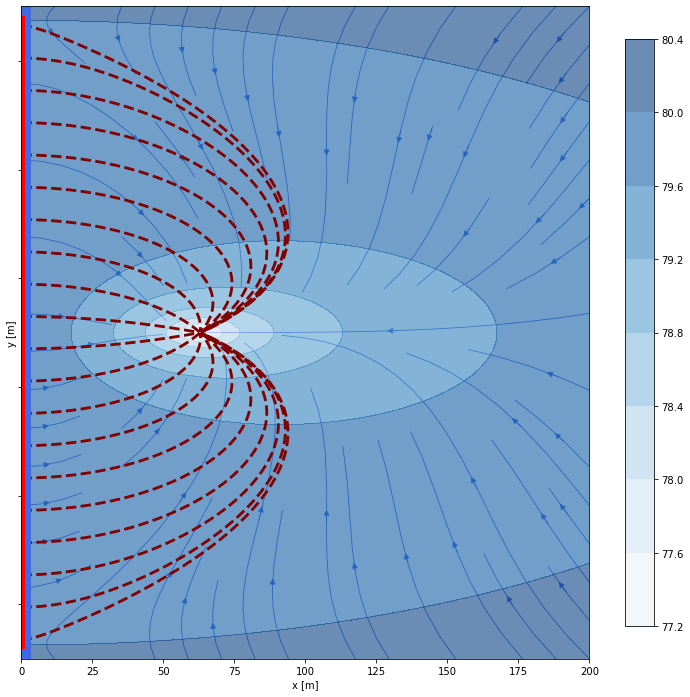

In [5]:
import plot

img = plot.plotting(0,200,-250,350,100,riv_coords)

# The plot 2d method optionally can contain the trajectory of the sampled particles and their travel time:
img.plot2d(aem_model, tt=None, ys = ys, traj_array = traj_array, levels=8, quiver=False, streams=True);

## Step 4. Add Clogging effect to the river

Now we check the model solution if we consider a clogging layer in the river bed with lower hydraulic conductivity. This will add a head difference between the river and the aquifer underneath.


In [7]:
## Add the clogging layer with the calc_clogging method:

Kd = 1e-6*3600*24 #Hydraulic conductivity of the clogging layer (1e-6 m/s, converted to days)
d = 0.5 #Thickness of the clogging layer [m]

aem_model.calc_clogging(Kd,d)

Now let's see how the solutions compare with the new model:

In [8]:

solv = solvers.river_length(aem_model)

print("River Capture Length, Capture position and contribution to discharge is:")
print(solv.solve_river_length())

# Here we collect all results from the first solve method:
#length: River capture lenght
# riv_coords: end point coordinates of the captured length
# capture_fraction: fraction of pumped water that is derived from the river.
length, riv_coords, capture_fraction = solv.solve_river_length()

#Here we collect all the results from the travel time method:
#tt: travel time array of particles
# ys: initial particle location
# avgtt: flow averaged time of travel
# mintt: minimum travel time
#traj_array: x and y location of the calculated trajectory of the particles (used for plotting)

tt, ys, avgtt, mintt, traj_array = solv.time_travel(0.2, delta_s = 0.1, min_dist_est = 5, calculate_trajectory = True)

print("Flow Averaged Time of Travel: "+str(np.round(avgtt,2)) + " [d]")
print("Minimum Time of Travel: "+str(np.round(mintt,2)) + " [d]")

River Capture Length, Capture position and contribution to discharge is:
(784.2511862584051, [-342.12559312920257, 442.12559312920257], 0.6285009738785998)
Flow Averaged Time of Travel: 371.29 [d]
Minimum Time of Travel: 50.05 [d]


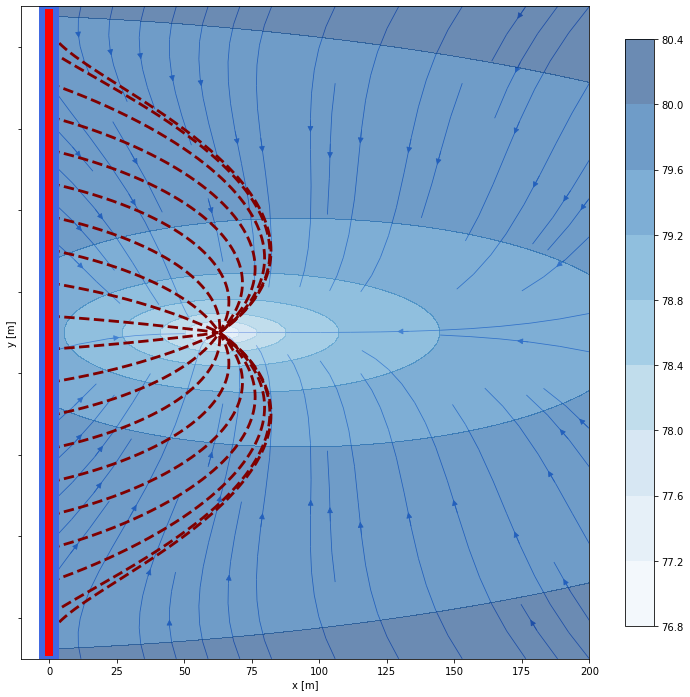

In [9]:
import plot

img = plot.plotting(0,200,-350,450,100,riv_coords)

# The plot 2d method optionally can contain the trajectory of the sampled particles and their travel time:
img.plot2d(aem_model, tt=None, ys = ys, traj_array = traj_array, levels=8, quiver=False, streams=True);